# g:Profiler Conversion

Lorem ipsum...

Note: our list of GO terms will not match the g:Profiler terms exactly, but should be consistent. This is expected! <-- Flesh this out

In [1]:
import re
from pathlib import Path

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from loguru import logger
from tqdm import tqdm

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
    plot_cluster,
    print_cluster,
)

In [2]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"

GO_DB = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

from pathlib import Path
IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img")

---

## Load Files

In [3]:
cluster_dict = load_cluster_json(cluster_file_path)
go_database = parse_GO_database(GO_DB)
full_G = nx.read_weighted_edgelist(network_file_path, delimiter="\t")

---

## Map to g:Profiler LOC IDs

- Download reference Ensembl genome
    ```bash
    $ wget  http://ftp.ensemblgenomes.org/pub/metazoa/release-59/fasta/pocillopora_damicornis_gca003704095v1/pep/Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa
    ```

- Create BLAST database
    ```bash
    $ makeblastdb -dbtype prot -title pdam_loc_db Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa
    ```

- Search against BLAST db
    ```bash
    $ ...
    ```

In [4]:
pdam_ensembl_fasta = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240930-gProfiler/Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa"
pdam_blast_results = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240930-gProfiler/pdam_loc_blast_results.tsv"

In [5]:
blast_results = (
    pd.read_csv(pdam_blast_results, sep="\t", header=None)
    .sort_values(0)
    .drop_duplicates([0, 1])
    .set_index(0)
)
blast_results = blast_results[blast_results[10] < 1e-5]
logger.info(f"{len(blast_results)} hits with e-value < 1e-5")
logger.info(f"{len(blast_results[1].unique())} unique hits")

2024-10-13 17:15:38.716 | INFO     | __main__:<module>:8 - 21894 hits with e-value < 1e-5
2024-10-13 17:15:38.722 | INFO     | __main__:<module>:9 - 17436 unique hits


In [6]:
blast_results.head()

,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,
pdam_00000001-RA,XP_027056588.1,100.000,360,0,0,1,360,31,390,0.000000e+00,737.0
pdam_00000002-RA,XP_027056458.1,93.440,747,14,2,1,712,13,759,0.000000e+00,1417.0
pdam_00000003-RA,XP_027056664.1,100.000,333,0,0,1,333,1,333,0.000000e+00,701.0
pdam_00000005-RA,XP_027056460.1,71.429,63,18,0,1,63,170,232,2.550000e-27,102.0
pdam_00000006-RA,XP_027056665.1,88.066,243,29,0,1,243,1,243,2.120000e-159,446.0


In [7]:
pep_fasta = SeqIO.to_dict(SeqIO.parse(pdam_ensembl_fasta, "fasta"))

REGEXP = ".*gene:(LOC\\d+) .*"
regcomp = re.compile(REGEXP)

xp_loc_map = {}
for k, v in pep_fasta.items():
    try:
        locid = regcomp.search(v.description).group(1)
        xp_loc_map[k] = locid
    except AttributeError:
        logger.warning(f"No match for {v.name}")

2024-10-13 17:15:39.966 | WARNING  | __main__:<module>:12 - No match for YP_001456710.1
2024-10-13 17:15:39.973 | WARNING  | __main__:<module>:12 - No match for YP_001456705.1
2024-10-13 17:15:39.975 | WARNING  | __main__:<module>:12 - No match for YP_001456711.1
2024-10-13 17:15:39.978 | WARNING  | __main__:<module>:12 - No match for YP_001456716.1
2024-10-13 17:15:39.979 | WARNING  | __main__:<module>:12 - No match for YP_001456704.1
2024-10-13 17:15:39.980 | WARNING  | __main__:<module>:12 - No match for YP_001456712.1
2024-10-13 17:15:39.981 | WARNING  | __main__:<module>:12 - No match for YP_001456714.1
2024-10-13 17:15:39.981 | WARNING  | __main__:<module>:12 - No match for YP_001456703.1
2024-10-13 17:15:39.982 | WARNING  | __main__:<module>:12 - No match for YP_001456708.1
2024-10-13 17:15:39.985 | WARNING  | __main__:<module>:12 - No match for YP_001456707.1
2024-10-13 17:15:39.985 | WARNING  | __main__:<module>:12 - No match for YP_001456706.1
2024-10-13 17:15:39.990 | WARNIN

---

## View g:Profiler Enrichment for a cluster

In [8]:
from gprofiler import GProfiler

gp = GProfiler(
    user_agent="ExampleTool",  # optional user agent
    return_dataframe=True,  # return pandas dataframe or plain python structures
)
PDAM_ORGANISM = "pdgca003704095v1"

In [9]:
def cluster_name_map(c, blast_map, loc_map):
    mapped_names = []
    for pdam_id in c["members"]:
        try:
            mapped_names.append(loc_map[blast_map.loc[pdam_id, 1]])
        except (KeyError, IndexError):
            logger.warning(f"{pdam_id} had no match in blast results")
    return mapped_names

In [10]:
# logger.disable("__main__")
# for k, cl in tqdm(cluster_dict.items(), total=len(cluster_dict)):
#     cl["members_loc"] = cluster_name_map(cl, blast_results, xp_loc_map)
#     cl["gprofiler"] = gp.profile(
#         organism=PDAM_ORGANISM, query=cl["members_loc"], sources=["GO:BP"]
#     )
# logger.enable("__main__")
# logger.info(f"Added gprofile annotations to {len(cluster_dict)} clusters")

# logger.info(
#     f"Writing results to {Path(cluster_file_path).with_suffix('.gprofile.pkl')}"
# )
# with open(Path(cluster_file_path).with_suffix(".gprofile.pkl"), "wb") as f:
#     import pickle

#     pickle.dump(cluster_dict, f)

with open(Path(cluster_file_path).with_suffix(".gprofile.pkl"), "rb") as f:
    import pickle

    cluster_dict = pickle.load(f)

In [16]:
# k = "889733293002804025" # purple
k = "803905878821692717" # orange

In [17]:
print_cluster(cluster_dict[k], go_database, n_terms=10)

Cluster of 12 proteins [pdam_00001381-RA, pdam_00006156-RA, pdam_00012376-RA, ...] (hash 803905878821692717)
8 proteins re-added by ReCIPE (degree, 0.75)
Edges: 8
Triangles: 0
Max Degree: 3
Top Terms:
		GO:0001964 - <startle response> (9)
		GO:0098703 - <calcium ion import across plasma membrane> (9)
		GO:0045188 - <regulation of circadian sleep/wake cycle, non-REM sleep> (9)
		GO:0071805 - <potassium ion transmembrane transport> (7)
		GO:0071361 - <cellular response to ethanol> (7)
		GO:0001988 - <positive regulation of heart rate involved in baroreceptor response to decreased systemic arterial blood pressure> (7)
		GO:0017085 - <response to insecticide> (7)
		GO:0035095 - <behavioral response to nicotine> (7)
		GO:0060013 - <righting reflex> (7)
		GO:0021771 - <lateral geniculate nucleus development> (7)



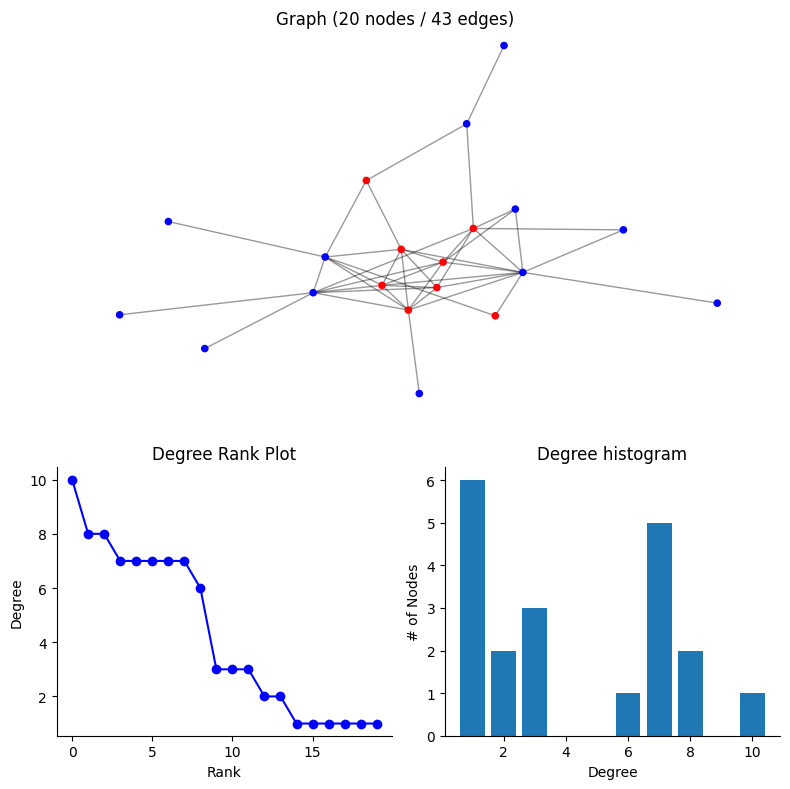

In [18]:
plot_cluster(cluster_dict[k], full_G)

In [19]:
for i in cluster_dict[k]["members_loc"]:
    print(i)

LOC113686642
LOC113684890
LOC113677094
LOC113686560
LOC113669729
LOC113674833
LOC113667632
LOC113686561
LOC113684421
LOC113673758
LOC113677265
LOC113684422


In [20]:
print(cluster_dict[k]["gprofiler"][["native","name","p_value"]].to_markdown())

|    | native     | name                                   |     p_value |
|---:|:-----------|:---------------------------------------|------------:|
|  0 | GO:0034220 | monoatomic ion transmembrane transport | 7.18524e-08 |
|  1 | GO:0006811 | monoatomic ion transport               | 1.60755e-07 |
|  2 | GO:0055085 | transmembrane transport                | 1.64134e-05 |
|  3 | GO:0051179 | localization                           | 3.85863e-05 |
|  4 | GO:0006810 | transport                              | 0.000764192 |
|  5 | GO:0051234 | establishment of localization          | 0.000880584 |


In [51]:
def dataframe_to_svg(df, filename='table.svg', figsize=(10, 6)):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Hide axes
    ax.axis('off')
    
    # Create the table and add it to the axis
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='left',
                     loc='center')
    
    # Adjust table style
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)  # Adjust the scale to change cell size
    
    # Save the figure as SVG
    plt.tight_layout()
    # plt.savefig(filename, format='svg', bbox_inches='tight')
    # plt.close()
    plt.show()

    return filename

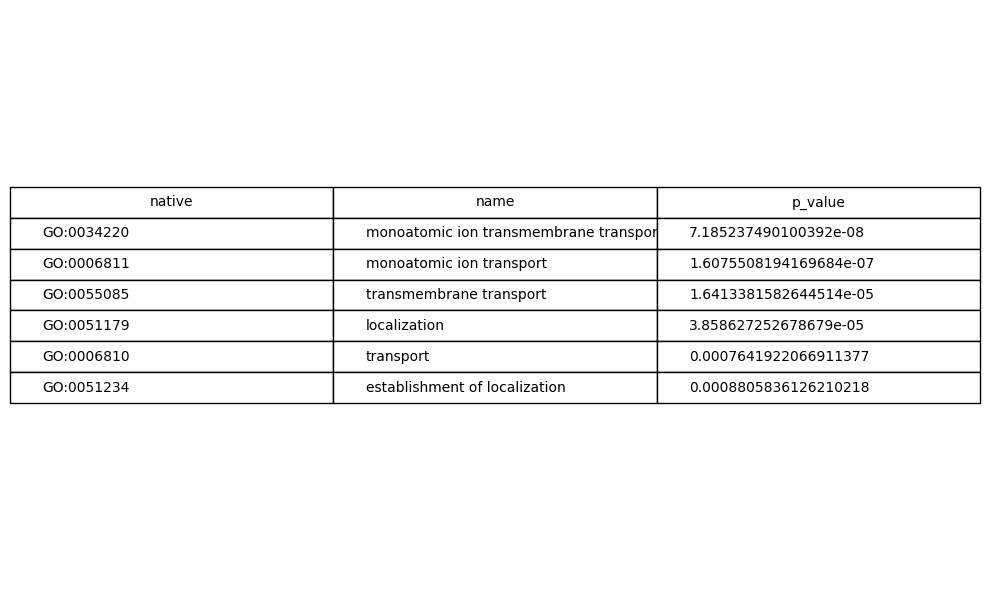

'table.svg'

In [52]:
dataframe_to_svg(cluster_dict[k]["gprofiler"][["native","name","p_value"]])

---